# **Building an Expected Goals (xG) Model**

## **Introduction**

Expected Goals (xG) is a statistical measure used in football analytics to estimate the likelihood of a shot resulting in a goal. This project aims to build an xG model using a dataset of football events, exploring the factors that influence the probability of scoring a goal. By analyzing features such as shot location, body part used, and the type of assist, we can derive meaningful insights and construct a predictive model.

---

## **Section 1: Data Understanding and Preparation**

The first step involves loading the events dataset (`events.csv`) into a Pandas DataFrame for analysis.


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [34]:
events = pd.read_csv('events.csv')
print(events.head())

     id_odsp   id_event  sort_order  time  \
0  UFot0hit/  UFot0hit1           1     2   
1  UFot0hit/  UFot0hit2           2     4   
2  UFot0hit/  UFot0hit3           3     4   
3  UFot0hit/  UFot0hit4           4     7   
4  UFot0hit/  UFot0hit5           5     7   

                                                text  event_type  event_type2  \
0  Attempt missed. Mladen Petric (Hamburg) left f...           1         12.0   
1  Corner,  Borussia Dortmund. Conceded by Dennis...           2          NaN   
2  Corner,  Borussia Dortmund. Conceded by Heiko ...           2          NaN   
3           Foul by Sven Bender (Borussia Dortmund).           3          NaN   
4  Gokhan Tore (Hamburg) wins a free kick in the ...           8          NaN   

   side         event_team           opponent  ... player_in player_out  \
0     2         Hamburg SV  Borussia Dortmund  ...       NaN        NaN   
1     1  Borussia Dortmund         Hamburg SV  ...       NaN        NaN   
2     1  Borussia

Now we need to sort the data so it only includes relevant information to xG. First we need to include only shot events. Then only include necessary columns. We will also drop rows with missing values for simplicity.

In [35]:
shots = events[events['event_type'] == 1]
columns_to_keep = ['location', 'shot_place', 'shot_outcome', 'bodypart', 
                   'assist_method', 'situation', 'side', 'is_goal']
shots = shots[columns_to_keep]
shots = shots.dropna()
print(shots.head())
print(shots.count())

    location  shot_place  shot_outcome  bodypart  assist_method  situation  \
0        9.0         6.0           2.0       2.0              1        1.0   
11      15.0        13.0           2.0       1.0              1        1.0   
13       9.0         4.0           1.0       2.0              1        1.0   
14      15.0         2.0           3.0       1.0              0        1.0   
17      15.0         2.0           3.0       1.0              0        1.0   

    side  is_goal  
0      2        0  
11     1        0  
13     1        1  
14     1        0  
17     2        0  
location         227452
shot_place       227452
shot_outcome     227452
bodypart         227452
assist_method    227452
situation        227452
side             227452
is_goal          227452
dtype: int64


Now lets take a look at a couple graphs. One for where are most shots taken, and what is the outcome of the shots?

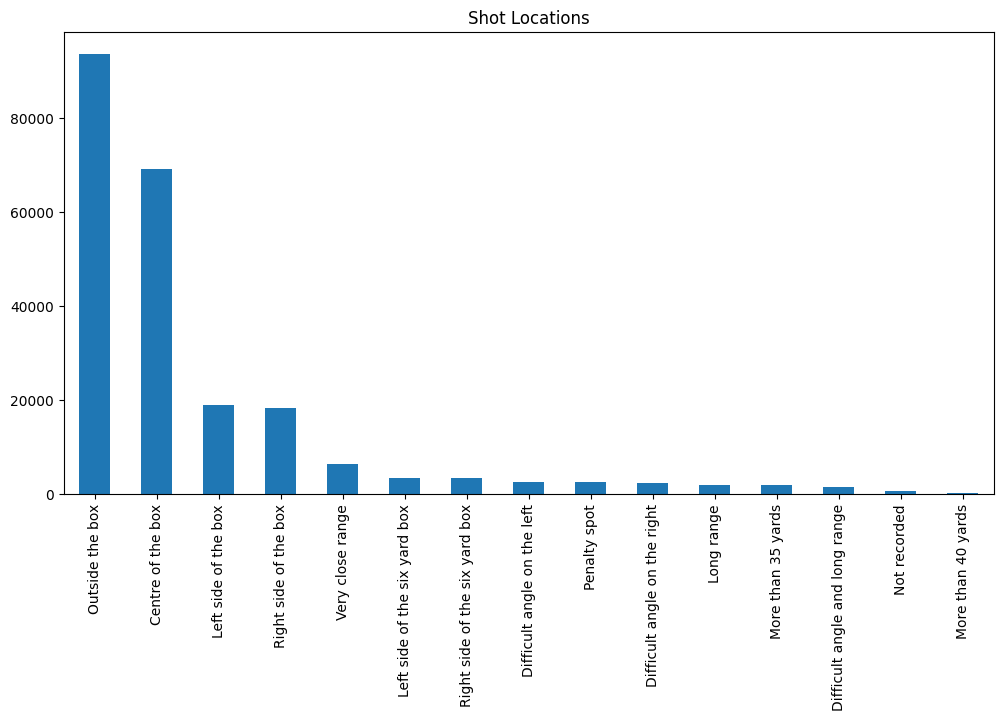

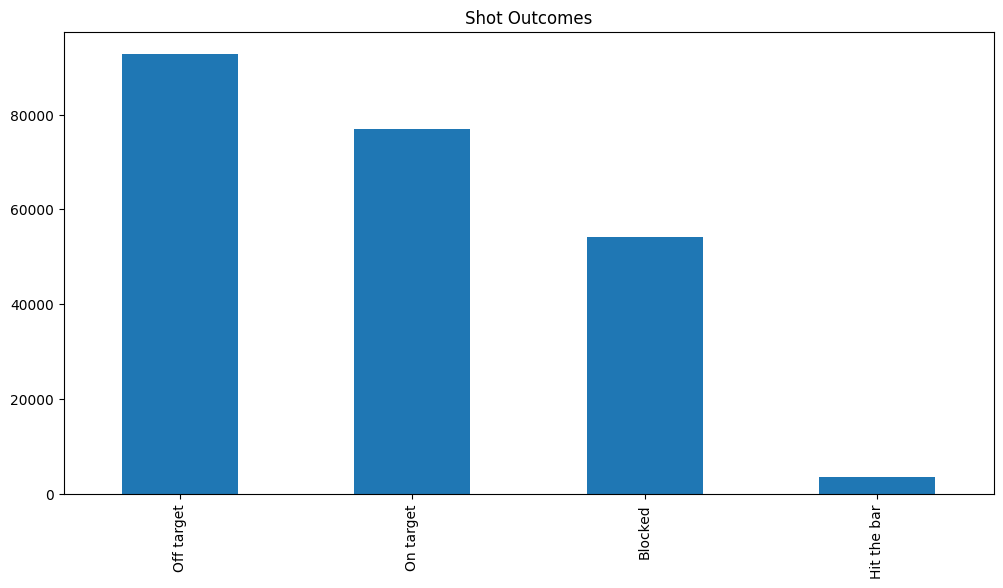

In [36]:
location_labels = [
    'Attacking half', 'Defensive half', 'Centre of the box', 
    'Left wing', 'Right wing', 'Difficult angle and long range', 
    'Difficult angle on the left', 'Difficult angle on the right',
    'Left side of the box', 'Left side of the six yard box',
    'Right side of the box', 'Right side of the six yard box',
    'Very close range', 'Penalty spot', 'Outside the box', 
    'Long range', 'More than 35 yards', 'More than 40 yards', 
    'Not recorded'
]
location_counts = shots['location'].value_counts()
location_counts.index = [location_labels[int(i) - 1] for i in location_counts.index]
location_counts.plot(kind='bar', figsize=(12, 6), title="Shot Locations")
plt.show()

outcome_labels = ['On target', 'Off target', 'Blocked', 'Hit the bar']
outcome_counts = shots['shot_outcome'].value_counts()
outcome_counts.index = [outcome_labels[int(i) - 1] for i in outcome_counts.index]
outcome_counts.plot(kind='bar', figsize=(12, 6), title="Shot Outcomes")
plt.show()

The first graph shows the frequency of the location of where each shot took place. The most common is outside the box with just under 100,000 shots. This is a little under half of all the shots taken in this dataset (approximately 229,000). The next highest is centre of the box with approximately 70,000 shots and then a drop off for the rest of the shots. The second graph displays the outcome of the shot, almost 100,000 of these shots were off target and almost 80,000 were almost on target. The number of blocked shots was approximately 60,000 too. 

# Section 2: Preparing the Dataset for xG Modeling

This section would involve cleaning, feature engineering, and ensuring that the dataset is structured in a way that can effectively contribute to the creation of an xG model.

Now let's approximate the distance each shot is from goal.

In [37]:
def calculate_distance(location):
    distance_map = {
        1: 50, 2: 50, 3: 10, 4: 15, 5: 15, 6: 30, 7: 25, 8: 25, 9: 12, 10: 5,  11: 12, 12: 5, 13: 3, 14: 11, 15: 20, 
        16: 25, 17: 35, 18: 40, 19: 25   
    }
    return distance_map.get(location, 25)

shots['distance_from_goal'] = shots['location'].apply(calculate_distance)
print(shots.head())

    location  shot_place  shot_outcome  bodypart  assist_method  situation  \
0        9.0         6.0           2.0       2.0              1        1.0   
11      15.0        13.0           2.0       1.0              1        1.0   
13       9.0         4.0           1.0       2.0              1        1.0   
14      15.0         2.0           3.0       1.0              0        1.0   
17      15.0         2.0           3.0       1.0              0        1.0   

    side  is_goal  distance_from_goal  
0      2        0                  12  
11     1        0                  20  
13     1        1                  12  
14     1        0                  20  
17     2        0                  20  


Now we want to select the features and target. The target variable will be is_goal, and the feature variables are location, shot_place, shot_outcome, bodypart, assist_method, situation, side, and distance_from_goal. Since several of these features are categorical, we will apply one-hot encoding to the categorical features to ensure that logistic regression treats them correctly as distinct categories without assuming any ordinal relationship. We will then split the two into a feature matrix 'X' and a target vector 'y'.

In [38]:

feature_columns = ['location', 'shot_place', 'shot_outcome', 'bodypart', 
                   'assist_method', 'situation', 'side', 'distance_from_goal']
categorical_columns = ['location', 'shot_place', 'shot_outcome', 'bodypart', 
                       'assist_method', 'situation', 'side']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ], remainder='passthrough'
)
xg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=500))
])
X = shots[feature_columns]
y = shots['is_goal']
print("Feature matrix (X):")
print(X.head())
print("\nTarget vector (y):")
print(y.head())

Feature matrix (X):
    location  shot_place  shot_outcome  bodypart  assist_method  situation  \
0        9.0         6.0           2.0       2.0              1        1.0   
11      15.0        13.0           2.0       1.0              1        1.0   
13       9.0         4.0           1.0       2.0              1        1.0   
14      15.0         2.0           3.0       1.0              0        1.0   
17      15.0         2.0           3.0       1.0              0        1.0   

    side  distance_from_goal  
0      2                  12  
11     1                  20  
13     1                  12  
14     1                  20  
17     2                  20  

Target vector (y):
0     0
11    0
13    1
14    0
17    0
Name: is_goal, dtype: int64


# Section 3: Building the xG 

In this section we will build an expected goals (xG) model to predict the likelihood of a shot resulting in a goal based on various features, such as shot location, body part used, and distance from goal. 

Specifically, we will:

1. Split the data into training and testing sets to ensure we can evaluate the model's performance.
2. Train a logistic regression model to predict the probability of a shot becoming a goal.
3. Evaluate the model using key metrics like accuracy, precision, recall, and the area under the ROC curve (AUC).
4. Analyze the feature importance to understand which factors contribute the most to scoring a goal.
5. Visualize the model's performance and its interpretation.

By the end of this section, we aim to have a well-performing model and insights into the key drivers of scoring probability.


We will start by splitting the dataset into a training set (80%) and a testing set (20%). The training set will be used to train the model, while the testing set will help evaluate how well the model generalizes to unseen data. 

Splitting the data ensures that the model is not overfitting, as it is tested on data it has never seen before.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
xg_model.fit(X_train, y_train)

Training set size: 181961 samples
Testing set size: 45491 samples


c:\Users\damia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['location', 'shot_place',
                                                   'shot_outcome', 'bodypart',
                                                   'assist_method', 'situation',
                                                   'side'])])),
                ('classifier',
                 LogisticRegression(max_iter=500, random_state=42))])

We are now going to evaluate the model on the testing set using a variety of metrics such as, accuracy (overall percentage of correct predictions), precision (percentage of predicted goals that are actual goals), recall (percentage of actual goals correctly predicted), and area under curve (a measure of how well the model separates goals from non-goals).

Accuracy: 0.939
Precision: 0.725
Recall: 0.622
AUC: 0.962


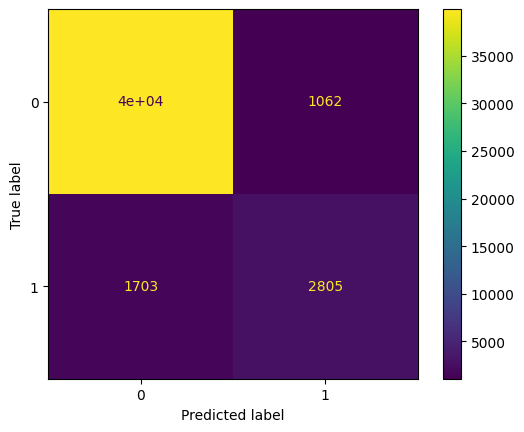

In [40]:
y_pred = xg_model.predict(X_test)
y_pred_prob = xg_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"AUC: {auc:.3f}")

These results tell us that the model performs very well in terms of overall accurary and AUC, which suggests it can distinguish between goals and non-goals effectively. However, the low recall indicates that while the model is good at predicting non-goals (or avoiding false positives), it misses a significant number of actual goals. 

We are now going to examine models coefficients to understand the importance of each feature. Features with higher coefficients have a greater influence on the probability of scoring a goal. 

In [41]:
encoded_feature_names = xg_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_columns)
final_feature_names = list(encoded_feature_names) + ['distance_from_goal']
coefficients = pd.DataFrame({'Feature': final_feature_names, 'Coefficient': xg_model.named_steps['classifier'].coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print("Feature Importance:")
print(coefficients)

Feature Importance:
               Feature  Coefficient
28    shot_outcome_1.0     7.884278
14       location_19.0     3.267032
27     shot_place_13.0     2.915943
26     shot_place_12.0     2.807971
17      shot_place_3.0     2.573791
18      shot_place_4.0     2.428304
42       situation_3.0     2.355926
43       situation_4.0     1.663498
8        location_13.0     1.249031
19      shot_place_5.0     1.132377
2         location_7.0     0.400946
3         location_8.0     0.335575
0         location_3.0     0.258207
39     assist_method_4     0.215858
12       location_17.0     0.116789
13       location_18.0    -0.045962
7        location_12.0    -0.060934
46  distance_from_goal    -0.107640
5        location_10.0    -0.219257
41       situation_2.0    -0.236366
33        bodypart_2.0    -0.281911
32        bodypart_1.0    -0.291524
1         location_6.0    -0.369929
36     assist_method_1    -0.390880
35     assist_method_0    -0.469413
15      shot_place_1.0    -0.476846
37     a